In [22]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import calculate_cleavage_rate as clv
import Nucleaseq_data_processing as processing
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()

In [78]:
goodsim = [4,5,6,7,9,13,17,21,26,31,33,35,47,49,50]
#goodsim = range(1,51)
parameters = np.zeros([len(goodsim),42])
for i in range(len(goodsim)):
    filename = '../data/22_3_2019/fit_22_3_2019_sim_' + str(goodsim[i]) + '.txt'
    data = pd.read_table(filename,index_col=False)
    final_par = data.loc[len(data)-1,'Parameter 1':'Parameter 43']
    final_par_np = final_par.values
    parameters[i][0:40] = final_par_np[1:41] #epsilon (no PAM)
    parameters[i][40] = final_par_np[42] #internal
    parameters[i][41] = 3.0 #cleavage

In [82]:
modelIDcleave = 'Clv_Saturated_general_energies_v2'
guide = 20
datafile = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
xdata, ydata, yerror = processing.prepare_multiprocessing_nucleaseq(datafile, path_to_data, False)
_,_,errormedian = processing.prepare_multiprocessing_nucleaseq(datafile, path_to_data, True)

chi = list()
for i in range(len(goodsim)):
    chitemp = 0.0
    for pos in range(len(xdata)):
        chitemp = chitemp + clv.calc_chi_squared(parameters[i],xdata[pos],ydata[pos],yerror[pos],guide,modelIDcleave)
        if i==41:
            print chitemp
    chi.append(chitemp)    
chi = np.array(chi)
    
print  'best fit: ' + str(goodsim[np.argmin(chi)])
print 'lowest chi^2: ' + str(chi[np.argmin(chi)])
print parameters[np.argmin(chi)]
print chi

best fit: 4
lowest chi^2: 3023039.8510986
[-3.91770873  1.95227568 -7.18523684  1.74413237  3.8621961  -2.16842391
  2.88748617 -2.17138089  3.10482887  1.76782213  1.613012    0.10089992
 -2.83986817  1.50219468 -1.31497921  2.68040566  4.28611139 -6.45366295
  2.04814047  9.41936818  7.90363495  2.86237141  7.72577178  7.3201194
  6.16059238  4.18570834  7.4480584   5.66903282  8.82195767  7.01118454
  6.91738637  5.79490889  6.09445674  6.80851504  6.035337    5.78967303
  5.08494143  4.21718008  8.63995518  3.67429637  2.20888348  3.        ]
[3.02303985e+06 1.52419867e+07 3.55315583e+08 4.40000458e+06
 1.91645518e+09 3.35254849e+07 6.55533369e+08 3.83212520e+06
 6.20432835e+07 1.80245436e+08 8.02587014e+06 4.22694288e+06
 1.82123389e+07 5.74241015e+07 7.95512208e+07]


0


Text(0.5,1,'double mismatches, top=model bottom=experiment')

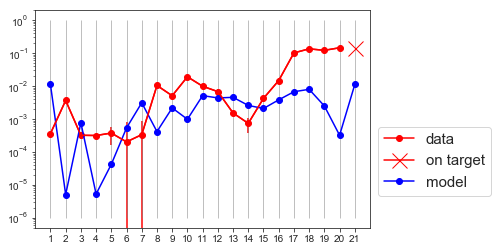

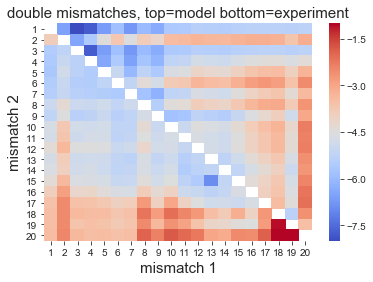

In [85]:
number = np.argmin(chi) #Choose which fit you want to see
print number
kclv = list()

for i in range(20):
    kclv.append(clv.calc_clv_rate_fast(parameters[number],modelIDcleave,[i],20))
kclv.append(clv.calc_clv_rate_fast(parameters[number],modelIDcleave,[],20))

kclvData = []
errormean = []

i = 1
while i < guide+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclvData.append(np.average(ydata[a], weights=np.reciprocal(yerror[a])))
            errormean.append(errormedian[a])
            i = i + 1
            
errormean.append(errormedian[0])
            
plt.figure()
plt.semilogy(range(1,21),kclvData,marker='o',color='r')
plt.semilogy(21,np.average(ydata[0],weights=np.reciprocal(yerror[0])),marker='x',color='r',markersize=15)
plt.semilogy(range(1,22),kclv,color='b',marker='o')
plt.errorbar(range(1,21),kclvData,errormean[0:20],None,color='r')
plt.vlines(range(1,22),10**-6,1,color='grey',linewidth=0.5);
plt.xticks(range(1,22));
plt.legend(['data','on target','model'],bbox_to_anchor=(1,0.5),fontsize=15)

k_double = np.zeros([20,20])
for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = np.log10(np.average(ydata[a], weights=np.reciprocal(yerror[a])))
        k_double[i-1,j-1] = np.log10(clv.calc_clv_rate_fast(parameters[number],modelIDcleave,[i,j],guide))
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    k_double_df[i].loc[i]=np.nan
        
plt.figure()
sns.heatmap(k_double_df, cmap='coolwarm', cbar=True, vmin=-8, vmax = -1)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)
plt.title('double mismatches, top=model bottom=experiment', fontsize=15)
